<a href="https://colab.research.google.com/github/mjsipes/tennis/blob/main/TennisProbability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to predict the probability of a tennis player winning a game given the probabilty of winning a single point.

In [9]:
import random
import time
from prettytable import PrettyTable
import pprint


NUMSETS = 3
NUMGAMES = 6
NUMPOINTS = 4
NUMPOINTSTIEBREAK = 7
RECURSIVECAP = 20
DEBUG = False
MATCHTRACKING = True
COLOROUTPUT = True

In [ ]:

class MatchState():
  def __init__(self):
    self.p_a_win_point_on_serve = .5
    self.p_a_win_point_returning_serve = .5

    self.ad = True
    self.a_points = 0
    self.b_points = 0
    self.a_games = 0
    self.b_games = 0
    self.a_sets = 0
    self.b_sets = 0

    self.p_a_win_game = 0
    self.p_b_win_game = 0
    self.p_a_win_set = 0
    self.p_b_win_set = 0
    self.p_a_win_match = 0
    self.p_b_win_match = 0

    self.server = 'a'
    self.tiebreaker_save_next_server = self.server
    self.tiebreaker_first_serve = False
    self.point_ID = 0
    self.winner = None
    self.match_history = []

    self.game_cache = {}
    self.set_cache = {}
    self.tiebreaker_cache = {}
    self.match_cache = {}


  def playPoint(self):
    if self.server == 'a':
      p_a_win_point = self.p_a_win_point_on_serve
    elif self.server == 'b':
      p_a_win_point = self.p_a_win_point_returning_serve

    if (random.random() < p_a_win_point):
      self.increment('a', 'points')
    else:
      self.increment('b', 'points')

  def playGame(self):
    self.reset_points()

    while self.a_points < NUMPOINTS and self.b_points < NUMPOINTS:
       self.playPoint()

    if self.a_points > self.b_points + 1:
      self.increment('a', 'games')
    elif self.a_points + 1 < self.b_points:
      self.increment('b', 'games')
    else:
      self.playDeuce()

    self.server = 'b' if self.server == 'a' else 'a'


  def playDeuce(self):
      if self.ad:
        while abs(self.a_points - self.b_points) < 2:
          self.playPoint()
      else:
        self.playPoint()

      if self.a_points > self.b_points:
          self.increment('a', 'games')
      else:
          self.increment('b', 'games')


  def playSet(self):
    self.reset_games()

    while self.a_games < NUMGAMES and self.b_games < NUMGAMES:
      self.playGame()
    if self.a_games > self.b_games + 1:
      self.increment('a', 'sets')
    elif self.a_games + 1 < self.b_games:
      self.increment('b', 'sets')
    else:
      self.playGame()
      if self.a_games > self.b_games + 1:
        self.increment('a', 'sets')
      elif self.a_games + 1 < self.b_games:
        self.increment('b', 'sets')
      else:
        self.tiebreaker_save_next_server = self.server
        self.playTieBreaker()
        self.server = self.tiebreaker_save_next_server


  def playTieBreaker(self):
    self.reset_points()
    self.tiebreaker_first_serve = False

    while self.a_points < NUMPOINTSTIEBREAK and self.b_points < NUMPOINTSTIEBREAK:
      self.playPoint()
      if self.tiebreaker_first_serve == True:
        self.tiebreaker_first_serve = False
      elif self.tiebreaker_first_serve == False:
        self.tiebreaker_first_serve = True
        self.server = 'a' if self.server == 'b' else 'b'

    if self.a_points > self.b_points + 1:
      self.increment('a', 'sets')
    elif self.a_points + 1 < self.b_points:
      self.increment('b', 'sets')
    else:
      #win by 2 tie breaker
        while abs(self.a_points - self.b_points) < 2 and self.a_points < RECURSIVECAP and self.b_points < RECURSIVECAP:
          self.playPoint()
          if self.tiebreaker_first_serve == True:
            self.tiebreaker_first_serve = False
          elif self.tiebreaker_first_serve == False:
            self.tiebreaker_first_serve = True
            self.server = 'a' if self.server == 'b' else 'b'
        if self.a_points > self.b_points:
          self.increment('a', 'sets')
        elif self.a_points < self.b_points:
          self.increment('b', 'sets')


  def playTennis(self):
    self.reset_sets()
    #commented out to indicate that the class is not built to playtennis multiple times, more setup and cleanup would have to occur if we wanted to be able to play many times.
    # self.point_ID = 0

    while self.a_sets < NUMSETS and self.b_sets < NUMSETS:
      self.playSet()
    if self.a_sets > self.b_sets:
      self.winner = 'a'
    elif self.a_sets < self.b_sets:
      self.winner = 'b'


  def increment(self, player, metric):
    attributes = {'a': {'points': 'a_points', 'games': 'a_games', 'sets': 'a_sets'},'b': {'points': 'b_points', 'games': 'b_games', 'sets': 'b_sets'}}
    if player in attributes and metric in attributes[player]:
      if metric == 'points':
        if MATCHTRACKING:
          self.runPredictions()
          if self.match_history:
            self.match_history[-1]['d_p_a_win_game'] = self.p_a_win_game - self.match_history[-1]['p_a_win_game']
            self.match_history[-1]['d_p_b_win_game'] = self.p_b_win_game - self.match_history[-1]['p_b_win_game']
            self.match_history[-1]['d_p_a_win_set'] = self.p_a_win_set - self.match_history[-1]['p_a_win_set']
            self.match_history[-1]['d_p_b_win_set'] = self.p_b_win_set - self.match_history[-1]['p_b_win_set']
            self.match_history[-1]['d_p_a_win_match'] = self.p_a_win_match - self.match_history[-1]['p_a_win_match']
            self.match_history[-1]['d_p_b_win_match'] = self.p_b_win_match - self.match_history[-1]['p_b_win_match']

          message = player + " wins " + metric
          state_snapshot = {
              'point_ID': self.point_ID,
              'a_points': self.a_points,
              'b_points': self.b_points,
              'a_games': self.a_games,
              'b_games': self.b_games,
              'a_sets': self.a_sets,
              'b_sets': self.b_sets,
              'p_a_win_game': self.p_a_win_game,
              'p_b_win_game': self.p_b_win_game,
              'p_a_win_set': self.p_a_win_set,
              'p_b_win_set': self.p_b_win_set,
              'p_a_win_match': self.p_a_win_match,
              'p_b_win_match': self.p_b_win_match,
              'd_p_a_win_game': 0,
              'd_p_b_win_game': 0,
              'd_p_a_win_set': 0,
              'd_p_b_win_set': 0,
              'd_p_a_win_match': 0,
              'd_p_b_win_match': 0,
              'server': self.server,
              'winner': self.winner,
              'message': message
          }
          self.match_history.append(state_snapshot)
          self.point_ID+=1

      if DEBUG:
        print(f"[[{self.a_sets},{self.b_sets}],[{self.a_games},{self.b_games}],[{self.a_points},{self.b_points}]]", end=" <- ")
        print(f"[[{self.p_a_win_match:.2f}, {self.p_b_win_match:.2f}], [{self.p_a_win_set:.2f}, {self.p_b_win_set:.2f}], [{self.p_a_win_game:.2f}, {self.p_b_win_game:.2f}]]",end=" <- ")
        print(f"{self.server} serves", end=" <- ")
        print(f"{player} wins {metric}")

      #this statement always execute
      setattr(self, attributes[player][metric], getattr(self, attributes[player][metric]) + 1)


  def reset_points(self):
    self.a_points = 0
    self.b_points = 0

  def reset_games(self):
    self.a_games = 0
    self.b_games = 0
    self.reset_points()

  def reset_sets(self):
    self.a_sets = 0
    self.b_sets = 0
    self.reset_games()




  def predictGame(self, current_server, a_points, b_points):
      if (current_server, a_points, b_points) in self.game_cache:
        return self.game_cache[(current_server, a_points, b_points)]

      if a_points >= NUMPOINTS and a_points > b_points + 1 or a_points > RECURSIVECAP:
        return 1
      if b_points >= NUMPOINTS and b_points > a_points + 1 or b_points > RECURSIVECAP:
        return 0

      if current_server == 'a': p_a_win_point = self.p_a_win_point_on_serve
      elif current_server == 'b': p_a_win_point = self.p_a_win_point_returning_serve

      p_a_win_next_point_an_win_game = p_a_win_point * self.predictGame(current_server, a_points + 1, b_points)
      p_a_loose_next_point_an_win_game = (1 - p_a_win_point) * self.predictGame(current_server, a_points, b_points + 1)
      p_a_win_game = p_a_win_next_point_an_win_game + p_a_loose_next_point_an_win_game
      self.game_cache[(current_server, a_points, b_points)] = p_a_win_game
      return p_a_win_game

  #looks solid
  def predictSet(self,current_server, a_games, b_games):
      next_server = 'a' if current_server == 'b' else 'b'

      if (current_server, a_games, b_games) in self.set_cache:
        return self.set_cache[(current_server, a_games, b_games)]

      if (a_games >= 6 and a_games > b_games+1):
        return (1.0, 1.0 if current_server == 'a' else 0.0)
      if (b_games >= 6 and b_games > a_games+1):
        return (0.0, 1.0 if current_server == 'a' else 0.0)

      #squash bug
      if a_games == 7: return (1.0, 1.0 if current_server == 'a' else 0.0)
      if b_games == 7: return (0.0, 1.0 if current_server == 'a' else 0.0)

      if a_games == 6 and b_games == 6:
        p_a_win_tiebreaker = self.predictTiebreaker(current_server, False, 0,0)
        return (p_a_win_tiebreaker, 1.0 if current_server == 'a' else 0.0)

      p_a_win_game = self.predictGame(current_server, 0, 0)
      p_a_win_set_given_win_game, p_a_next_server_given_win_game = self.predictSet(next_server, a_games + 1, b_games)
      p_a_win_set_given_loose_game, p_a_next_server_given_loose_game = self.predictSet(next_server, a_games, b_games + 1)
      p_a_win_set = p_a_win_game * p_a_win_set_given_win_game + (1 - p_a_win_game) * p_a_win_set_given_loose_game
      p_a_serves_next = p_a_win_game * p_a_next_server_given_win_game + (1 - p_a_win_game) * p_a_next_server_given_loose_game
      self.set_cache[(current_server, a_games, b_games)] = (p_a_win_set, p_a_serves_next)
      return (p_a_win_set, p_a_serves_next)


  def predictTiebreaker(self, current_server, first_serve, a_points, b_points):
      if (current_server, first_serve, a_points, b_points) in self.tiebreaker_cache:
        return self.tiebreaker_cache[(current_server, first_serve, a_points, b_points)]

      if a_points >= NUMPOINTSTIEBREAK and a_points > b_points + 1: return 1
      if b_points >= NUMPOINTSTIEBREAK and a_points + 1 < b_points: return 0
      if a_points > NUMPOINTSTIEBREAK and b_points > NUMPOINTSTIEBREAK: return (self.p_a_win_point_on_serve + self.p_a_win_point_returning_serve)/2

      if current_server == 'a': p_a_win_point = self.p_a_win_point_on_serve
      elif current_server == 'b': p_a_win_point = self.p_a_win_point_returning_serve

      if first_serve == True:
        first_serve = False
      elif first_serve == False:
        first_serve = True
        current_server = 'b' if current_server == 'a' else 'a'

      p_a_win_tiebreaker_and_win_next_point = self.predictTiebreaker(current_server, first_serve, a_points + 1, b_points) * p_a_win_point
      p_a_win_tiebreaker_and_lose_next_point = self.predictTiebreaker(current_server,first_serve, a_points, b_points + 1) * (1 - p_a_win_point)
      p_a_win_tiebreaker = p_a_win_tiebreaker_and_win_next_point + p_a_win_tiebreaker_and_lose_next_point
      self.tiebreaker_cache[(current_server,first_serve, a_points, b_points)] = p_a_win_tiebreaker
      return p_a_win_tiebreaker


  def predictMatch(self,current_server,a_sets, b_sets):
      if (current_server, a_sets, b_sets) in self.match_cache:
          return self.match_cache[(current_server, a_sets, b_sets)]

      if a_sets >= NUMSETS: return 1.0
      if b_sets >= NUMSETS: return 0.0

      p_a_win_set, p_a_next_server = self.predictSet(current_server, 0, 0)
      p_a_win_match_and_win_next_set_and_serves_next = self.predictMatch('a', a_sets + 1, b_sets) * p_a_win_set * p_a_next_server
      p_a_win_match_and_lose_next_set_and_serves_next = self.predictMatch('a', a_sets, b_sets + 1) * (1 - p_a_win_set) * p_a_next_server
      p_a_win_match_and_win_next_set_and_recieves_next = self.predictMatch('b', a_sets + 1, b_sets) * p_a_win_set * (1-p_a_next_server)
      p_a_win_match_and_lose_next_set_and_recieves_next = self.predictMatch('b', a_sets, b_sets + 1) * (1 - p_a_win_set) * (1-p_a_next_server)
      p_a_win_match = p_a_win_match_and_win_next_set_and_serves_next + p_a_win_match_and_lose_next_set_and_serves_next + p_a_win_match_and_win_next_set_and_recieves_next + p_a_win_match_and_lose_next_set_and_recieves_next
      self.match_cache[(current_server, a_sets, b_sets)] = p_a_win_match
      return p_a_win_match

  def runPredictions(self):
    current_server = self.server
    next_server = 'a' if current_server == 'b' else 'b'
    #if tiebreaker
    if self.a_games == 6 and self.b_games == 6:
      self.p_a_win_game = self.predictTiebreaker(current_server, self.tiebreaker_first_serve, self.a_points, self.b_points)
      self.p_b_win_game = 1 - self.p_a_win_game
      self.p_a_win_set = self.p_a_win_game
      self.p_b_win_set = 1-self.p_a_win_set
      p_a_win_match_and_win_set = self.predictMatch(self.tiebreaker_save_next_server, self.a_sets + 1, self.b_sets) * self.p_a_win_set
      p_a_win_match_and_loose_set = self.predictMatch(self.tiebreaker_save_next_server, self.a_sets, self.b_sets + 1) * self.p_b_win_set
      self.p_a_win_match = p_a_win_match_and_win_set + p_a_win_match_and_loose_set
      self.p_b_win_match = 1-self.p_a_win_match
    #if generic point
    else:
      self.p_a_win_game = self.predictGame(current_server, self.a_points, self.b_points)
      self.p_b_win_game = 1-self.p_a_win_game

      p_a_win_set_given_win_game, p_a_serve_next_given_win_game= self.predictSet(next_server, self.a_games + 1, self.b_games)
      p_a_win_set_given_loose_game, p_a_serve_next_given_loose_game = self.predictSet(next_server, self.a_games, self.b_games + 1)
      self.p_a_win_set = p_a_win_set_given_win_game * self.p_a_win_game + p_a_win_set_given_loose_game * (1-self.p_a_win_game)
      self.p_b_win_set = 1-self.p_a_win_set
      p_a_serves_next = p_a_serve_next_given_win_game * self.p_a_win_game + p_a_serve_next_given_loose_game * (1-self.p_a_win_game)

      p_a_win_match_and_win_set_and_serves_next = self.predictMatch('a', self.a_sets + 1, self.b_sets) * self.p_a_win_set * p_a_serves_next
      p_a_win_match_and_win_set_and_recieves_next = self.predictMatch('b', self.a_sets + 1, self.b_sets) * self.p_a_win_set * (1-p_a_serves_next)
      p_a_win_match_and_loose_set_and_serves_next = self.predictMatch('a', self.a_sets, self.b_sets + 1) * self.p_b_win_set * p_a_serves_next
      p_a_win_match_and_loose_set_and_recieves_next = self.predictMatch('b', self.a_sets, self.b_sets + 1) * self.p_b_win_set * (1-p_a_serves_next)
      self.p_a_win_match = p_a_win_match_and_win_set_and_serves_next + p_a_win_match_and_win_set_and_recieves_next + p_a_win_match_and_loose_set_and_serves_next + p_a_win_match_and_loose_set_and_recieves_next
      self.p_b_win_match = 1-self.p_a_win_match




  def print_match_history(self):
      # Creating a PrettyTable object
      table = PrettyTable()

      # Adding column headers matching the dictionary keys in the desired order
      table.field_names = ["ID", "sets", "games", "points",
                          "p_a_w_m", "p_b_w_m", "p_a_w_s", "p_b_w_s",
                          "p_a_w_g", "p_b_w_g","server", "message", "d_p_a_w_m"]

      if COLOROUTPUT:
        RED = "\033[31m"
        GREEN = "\033[32m"
        RESET = "\033[0m"

        for entry in self.match_history:
            row = [
                entry['point_ID'],
                (entry['a_sets'], entry['b_sets']),
                (entry['a_games'], entry['b_games']),
                (entry['a_points'], entry['b_points']),
                GREEN + f"{entry['p_a_win_match']:.2f}" + RESET if entry['p_a_win_match'] > 0.5 else RED + f"{entry['p_a_win_match']:.2f}" + RESET if entry['p_a_win_match'] < 0.5 else f"{entry['p_a_win_match']:.2f}",
                GREEN + f"{entry['p_b_win_match']:.2f}" + RESET if entry['p_b_win_match'] > 0.5 else RED + f"{entry['p_b_win_match']:.2f}" + RESET if entry['p_b_win_match'] < 0.5 else f"{entry['p_b_win_match']:.2f}",
                GREEN + f"{entry['p_a_win_set']:.2f}" + RESET if entry['p_a_win_set'] > 0.5 else RED + f"{entry['p_a_win_set']:.2f}" + RESET if entry['p_a_win_set'] < 0.5 else f"{entry['p_a_win_set']:.2f}",
                GREEN + f"{entry['p_b_win_set']:.2f}" + RESET if entry['p_b_win_set'] > 0.5 else RED + f"{entry['p_b_win_set']:.2f}" + RESET if entry['p_b_win_set'] < 0.5 else f"{entry['p_b_win_set']:.2f}",
                GREEN + f"{entry['p_a_win_game']:.2f}" + RESET if entry['p_a_win_game'] > 0.5 else RED + f"{entry['p_a_win_game']:.2f}" + RESET if entry['p_a_win_game'] < 0.5 else f"{entry['p_a_win_game']:.2f}",
                GREEN + f"{entry['p_b_win_game']:.2f}" + RESET if entry['p_b_win_game'] > 0.5 else RED + f"{entry['p_b_win_game']:.2f}" + RESET if entry['p_b_win_game'] < 0.5 else f"{entry['p_b_win_game']:.2f}",
                entry['server'],
                entry['message'],
                GREEN + f"{entry['d_p_a_win_match']:.4f}" + RESET if entry['d_p_a_win_match'] > 0 else RED + f"{entry['d_p_a_win_match']:.4f}" + RESET if entry['d_p_a_win_match'] < 0 else f"{entry['d_p_a_win_match']:.4f}"
            ]
            table.add_row(row)
      else:
        for entry in self.match_history:
            row = [
                entry['point_ID'],
                (entry['a_sets'], entry['b_sets']),
                (entry['a_games'], entry['b_games']),
                (entry['a_points'], entry['b_points']),
                f"{entry['p_a_win_match']:.2f}",
                f"{entry['p_b_win_match']:.2f}",
                f"{entry['p_a_win_set']:.2f}",
                f"{entry['p_b_win_set']:.2f}",
                f"{entry['p_a_win_game']:.2f}",
                f"{entry['p_b_win_game']:.2f}",
                entry['server'],
                entry['message'],
                f"{entry['d_p_a_win_match']:.4f}"
            ]
            table.add_row(row)

      # Printing the table
      print(table)



In [11]:
#choose your initial conditions!

tennis_match = MatchState()
tennis_match.server = 'a'
tennis_match.p_a_win_point_on_serve = 0.5
tennis_match.p_a_win_point_returning_serve = 0.5
COLOROUTPUT = True

print("INPUT: ", "p_a_win_point_on_serve =", tennis_match.p_a_win_point_on_serve,
      ", p_a_win_point_returning_serve =", tennis_match.p_a_win_point_returning_serve,
      ", server =", tennis_match.server, ", NUMSETS =", NUMSETS)

start_time = time.time()
random.seed(43)
tennis_match.playTennis()
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

# pprint.pprint(tennis_match.match_history)
tennis_match.print_match_history()

INPUT:  p_a_win_point_on_serve = 0.5 , p_a_win_point_returning_serve = 0.5 , server = a , NUMSETS = 3
Execution time: 0.898298978805542 seconds
+-----+--------+--------+--------+---------+---------+---------+---------+---------+---------+--------+---------------+-----------+
|  ID |  sets  | games  | points | p_a_w_m | p_b_w_m | p_a_w_s | p_b_w_s | p_a_w_g | p_b_w_g | server |    message    | d_p_a_w_m |
+-----+--------+--------+--------+---------+---------+---------+---------+---------+---------+--------+---------------+-----------+
|  0  | (0, 0) | (0, 0) | (0, 0) |   0.50  |   0.50  |   0.50  |   0.50  |   0.50  |   0.50  |   a    | a wins points |   0.0144  |
|  1  | (0, 0) | (0, 0) | (1, 0) |   0.51  |   0.49  |   0.54  |   0.46  |   0.66  |   0.34  |   a    | b wins points |  -0.0144  |
|  2  | (0, 0) | (0, 0) | (1, 1) |   0.50  |   0.50  |   0.50  |   0.50  |   0.50  |   0.50  |   a    | a wins points |   0.0173  |
|  3  | (0, 0) | (0, 0) | (2, 1) |   0.52  |   0.48  |   0.55  |

In [12]:
#codeblock for debugging
# debug_match = MatchState()
# # debug_match.server = 'b'
# debug_match.p_a_win_point_on_serve = 0.5
# debug_match.p_a_win_point_returning_serve = 0.5
# # debug_match.predictSet('a', 6,5)
# RECURSIVECAP = 20
# debug_match.a_points = 4
# debug_match.b_points = 0
# debug_match.a_games = 5
# debug_match.b_games = 6
# debug_match.a_sets = 0
# debug_match.b_sets = 0


# debug_match.runPredictions()
# print(f"({debug_match.p_a_win_match},{debug_match.p_b_win_match}),({debug_match.p_a_win_set},{debug_match.p_b_win_set}),({debug_match.p_a_win_game},{debug_match.p_b_win_game})")

In [13]:
!install matplotlib

install: missing destination file operand after 'matplotlib'
Try 'install --help' for more information.


In [14]:
# #lets discover how longer versus shorter matches impact the probability a player wins
# DEBUG = False
# MATCHTRACKING = True

# num_sets = ["1","2", "3"]
# one_set_probability = []
# two_set_probability = []
# three_set_probability = []

# start_time = time.time()
# for set_count in num_sets:
#     NUMSETS = int(set_count)
#     for i in range(100):
#         tennis_match = MatchState()
#         tennis_match.server = 'a'
#         tennis_match.p_a_win_point_on_serve = i / 100
#         tennis_match.p_a_win_point_returning_serve = i / 100
#         tennis_match.playTennis()
#         # print(tennis_match.match_history)
#         p_win = tennis_match.match_history[0]['p_a_win_match']

#         if NUMSETS == 1:
#             one_set_probability.append((i, p_win))
#         elif NUMSETS == 2:
#             two_set_probability.append((i, p_win))
#         elif NUMSETS == 3:
#             three_set_probability.append((i, p_win))

# end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")

# print(one_set_probability[40:50])
# print(two_set_probability[40:50])
# print(three_set_probability[40:50])

Execution time: 31.97018313407898 seconds
[(40, 0.036669240316779025), (41, 0.05350064828950088), (42, 0.07594523925552424), (43, 0.10493731681397342), (44, 0.1412122040297324), (45, 0.18517377393990742), (46, 0.23677526007919636), (47, 0.29543715317052255), (48, 0.3600234129916673), (49, 0.4288890927387067)]
[(40, 0.003935286201401668), (41, 0.008280686218655966), (42, 0.016426982518000392), (43, 0.03072441539821239), (44, 0.054190866615956824), (45, 0.09016901165729455), (46, 0.14163913405666376), (47, 0.21027598647331436), (48, 0.2955203665801165), (49, 0.39405282085179266)]
[(40, 0.00046634399445574223), (41, 0.0014110962790904304), (42, 0.0038964444377722106), (43, 0.009812969046980799), (44, 0.02253128990932721), (45, 0.0471647884894971), (46, 0.09006220509494264), (47, 0.15709606334234175), (48, 0.250934592430726), (49, 0.36845409305354204)]


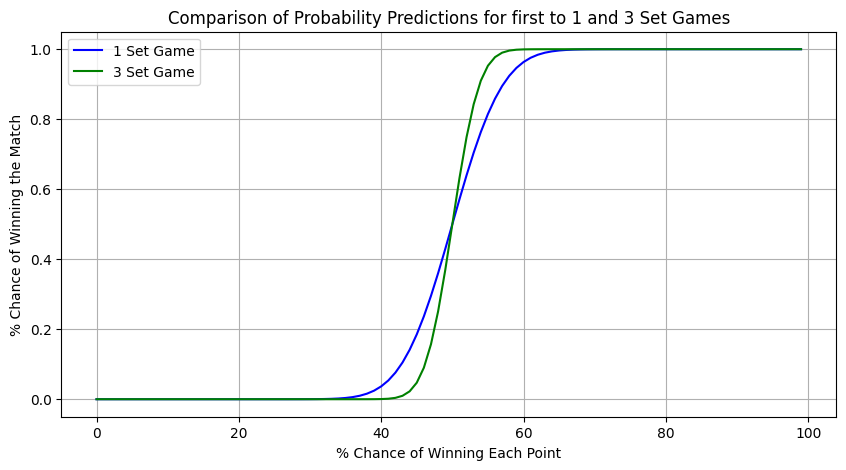

In [15]:
# import matplotlib.pyplot as plt

# # Unpack the probabilities for 1-set, 2-set, and 3-set games
# x_one_set_probability, y_one_set_probability = zip(*one_set_probability)
# x_two_set_probability, y_two_set_probability = zip(*two_set_probability)
# x_three_set_probability, y_three_set_probability = zip(*three_set_probability)

# # Create the plot
# plt.figure(figsize=(10, 5))
# plt.plot(x_one_set_probability, y_one_set_probability, label='1 Set Game', color='blue')
# plt.plot(x_three_set_probability, y_three_set_probability, label='3 Set Game', color='green')

# # Add titles and labels
# plt.title('Comparison of Probability Predictions for first to 1 and 3 Set Games')
# plt.xlabel('% Chance of Winning Each Point')
# plt.ylabel('% Chance of Winning the Match')
# plt.legend()
# plt.grid(True)
# plt.savefig('probability_comparison.png', dpi=300)
# plt.show()



In [16]:
# from pprint import pprint
# #we are going to find out what are the most important points
# gamestate_predictions = []
# tennis_match = MatchState()
# tennis_match.a_prob = 50
# for a_set in range (NUMSETS):
#   for b_set in range (NUMSETS):
#     for a_game in range (NUMGAMES):
#       for b_game in range (NUMGAMES):
#         for a_point in range (NUMPOINTS):
#           for b_point in range (NUMPOINTS):
#             tennis_match.a_points = a_point
#             tennis_match.b_points = b_point
#             tennis_match.a_games = a_game
#             tennis_match.b_games = b_game
#             tennis_match.a_sets = a_set
#             tennis_match.b_sets = b_set
#             tennis_match.runPredictions()
#             gamestate_predictions.append([[[a_set,b_set],[a_game,b_game],[a_point,b_point]],[[tennis_match.p_a_win_match, tennis_match.p_b_win_match],[tennis_match.p_a_win_set,tennis_match.p_b_win_set],[tennis_match.p_a_win_game,tennis_match.p_b_win_game]]])

# # Sort the gamestate_predictions by descending order of probability of player A winning the match
# sorted_gamestate_predictions = sorted(gamestate_predictions, key=lambda x: x[1][0][0], reverse=True)

# for gamestate in sorted_gamestate_predictions:
#     # Format the sets, games, and points data
#     sets_games_points = "[[{}, {}], [{}, {}], [{}, {}]]".format(*gamestate[0][0], *gamestate[0][1], *gamestate[0][2])

#     # Format the probabilities to two decimal places
#     probabilities = "[[{:.2f}, {:.2f}], [{:.2f}, {:.2f}], [{:.2f}, {:.2f}]]".format(*gamestate[1][0], *gamestate[1][1], *gamestate[1][2])

#     print(sets_games_points, "<-", probabilities)


